Loading Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, Pipeline

# text processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# model evaluation
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# pipeline and model selection
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

# working with strings
import re
import string

# # text libraries
# import nltk
# nltk.download('stopwords')

# # plot style
# import seaborn as sns
# sns.set_style("whitegrid")
# sns.set_context("poster")

## References

- Dataset from the original source: 'The SMS datasets consists of 5574 English, real and non-encoded messages, tagged as legitimate(ham) or spam'.  
http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/
- Blog post about the theory (Sebastian always has excellent material): http://sebastianraschka.com/Articles/2014_naive_bayes_1.html#References
- Harvard CS 109 (Data Science): awesome course and resources, especially the lab notebooks.

## Loading Data

In [4]:
sms = pd.read_csv('./data/SMSSpamCollection', sep='\t', header = None,
                  names = ['spam_ham', 'message'])

In [5]:
sms.head()

,spam_ham,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Checking that only two values are present on the dependent variable and converting categories to integers:

In [6]:
sms['spam_ham'].value_counts()

ham     4825
spam     747
Name: spam_ham, dtype: int64

In [7]:
sms['spam_ham'] = np.where(sms['spam_ham'] == 'spam', 1, 0)

In [8]:
X = sms['message']
y = sms['spam_ham']

The main characteristic of this dataset is that it is highly imbalanced:

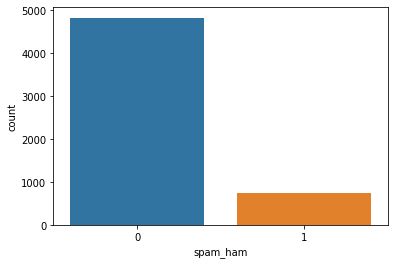

In [14]:
sns.countplot(sms['spam_ham']);

We will do more exploration of the dataset on the feature engineering section. We will start with some machine learning models and simple preprocessing first.

## Train-Validation-Test Split

Before further preprocessing, we need to separate the data in train, validation and test data. We will use the validation set to evaluate out-of-sample performance of our models. The test set will only be used in the end of this exercise, to evaluate the performance of the final model on previously unseen data (thus simulating a real scenario). We will use 80/10/10 division since we are getting two separate validation/train sets.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=42)

## Model Training - Initial Screening

Some helper functions:

In [9]:
def plot_roc(fpr, tpr, thr, auc, ax, thr_points=7):
    
    ax.plot([0,1], [0,1], '--')
    ax.plot(fpr, tpr, label = f'AUC:{auc:.2f}')
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_title('ROC Curve', fontsize=18)
    ax.legend(loc='lower right')
    
    steps = int(len(thr)/thr_points)
    if steps < 1:
        steps=1
    for idx, threshold in enumerate(thr):
        if idx%steps==0:
            annotation = str(np.round(threshold, 2))
            ax.annotate(annotation, (fpr[idx], tpr[idx]),
                        bbox={'alpha':0.2})
    

In [10]:
def plot_precision_recall(precision, recall, thr, ax, thr_points=7):
    
    ax.plot([0,1], [1,0], '--')
    ax.plot(recall, precision)
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_title('Precision-Recall Curve', fontsize=18)
    #ax.legend(loc='lower right')
    
    # Harvard CS 109 inspired
    steps = int(len(thr)/thr_points)
    if steps < 1:
        steps=1
    for idx, threshold in enumerate(thr):
        if idx%steps==0:
            annotation = str(np.round(threshold, 2))
            ax.annotate(annotation, (recall[idx], precision[idx]),
                        bbox={'alpha':0.2})

The function below preprocess the data (according to a given function method), trains the model and evaluates performance with a ROC curve and by calculating the area under the AOC curve. It also shows a confusion matrix and classification report.

In [1]:
def spam_filter(model, X_train, X_test, y_train, y_test, ax, *args):
    """ Spam filter with preprocessing and evaluation on a test set

    Parameters
    ----------
    model: sklearn classification mode (must have fit and predict methods)
    ax: list of axes for ROC and Precision-Recall curves
    *args: sklearn preprocessing methods used on the pipeline
    na_column : boolean, optional (default = 1)
        If true, will add columns keeping track of
        missing values on the original data

    """    
    # feature processing and model training
    if args:
        my_pipeline = make_pipeline(*args)
        X_train_proc = my_pipeline.fit_transform(X_train)
        X_test_proc = my_pipeline.transform(X_test)
    else:
        my_pipeline = None
        X_train_proc = X_train
        X_test_proc = X_test
        
    model.fit(X_train_proc, y_train)
    y_pred_prob = model.predict_proba(X_test_proc)[:, 1]
    y_pred = model.predict(X_test_proc)
    
    # ROC curve and AUC
    fpr, tpr, thr_roc = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Precision-Recall
    precision, recall, thr_pr = precision_recall_curve(y_test, y_pred_prob)
    
    # plots
    plot_roc(fpr, tpr, thr_roc, auc, ax[0])
    plot_precision_recall(precision, recall, thr_pr, ax[1])
    
    # model diagnostics
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    
    return dict(pipeline=my_pipeline,
                model=model,
                X_train_proc=X_train_proc, 
                X_test_proc=X_test_proc,
                y_pred_prob=y_pred_prob, 
                y_pred=y_pred)

We will evaluate the performance of 4 models: Logistic Regression, Random Forest, Bernoulli Naive Bayes and Multinomial Naive Bayes. For the preprocessing pipeline, we will start with a Tf-Idf vectorizer.

In [12]:
log_reg = LogisticRegression(solver='lbfgs', random_state=42, C=1)
rnd_for = RandomForestClassifier(n_estimators=100, random_state=42)
bern_nb = BernoulliNB()
mult_nb = MultinomialNB()

Logistic Regression:

Confusion Matrix:
[[485   0]
 [ 17  55]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       485
           1       1.00      0.76      0.87        72

    accuracy                           0.97       557
   macro avg       0.98      0.88      0.92       557
weighted avg       0.97      0.97      0.97       557



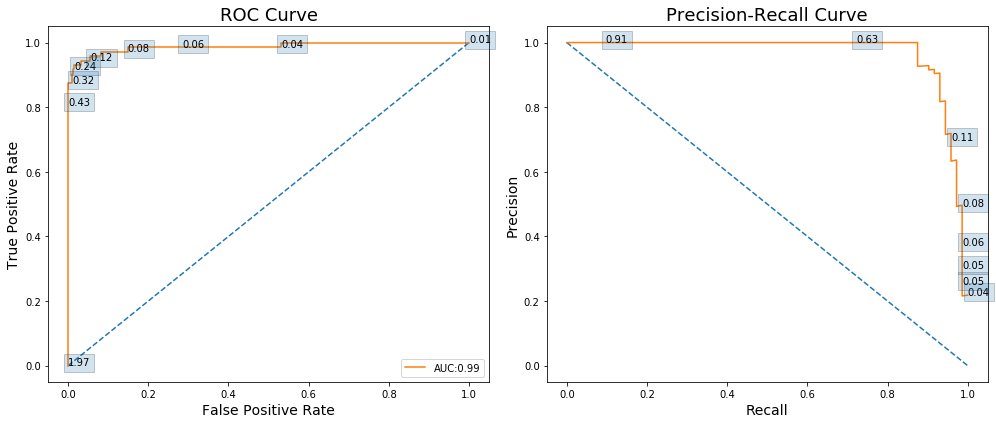

In [45]:
fig, ax = plt.subplots(1, 2,figsize=(14,6))

log_reg_filter=spam_filter(log_reg, X_train, X_valid, 
           y_train, y_valid, ax,
           TfidfVectorizer())
plt.tight_layout()

Random Forest:

Confusion Matrix:
[[485   0]
 [ 13  59]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       485
           1       1.00      0.82      0.90        72

    accuracy                           0.98       557
   macro avg       0.99      0.91      0.94       557
weighted avg       0.98      0.98      0.98       557



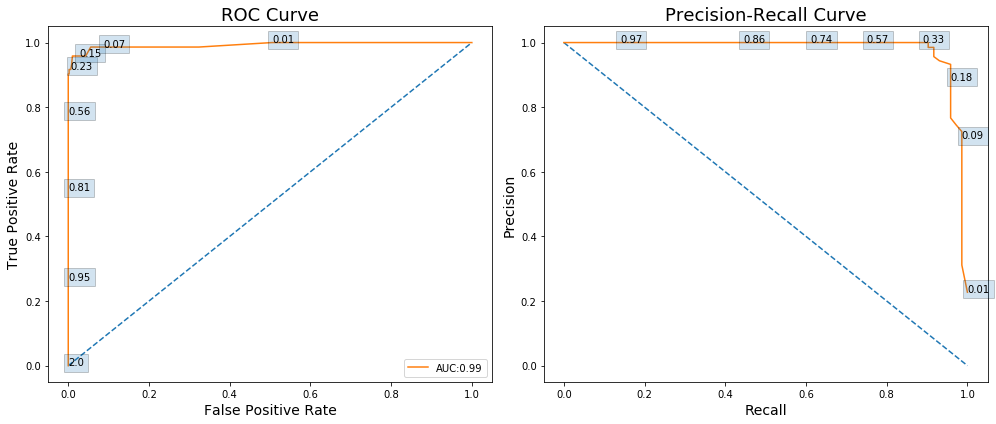

In [46]:
fig, ax = plt.subplots(1, 2,figsize=(14,6))

rnd_for_filter = spam_filter(rnd_for, X_train, X_valid, 
                             y_train, y_valid, ax, 
                             TfidfVectorizer())
plt.tight_layout()

Bernoulli Naive Bayes:

Confusion Matrix:
[[485   0]
 [ 14  58]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       485
           1       1.00      0.81      0.89        72

    accuracy                           0.97       557
   macro avg       0.99      0.90      0.94       557
weighted avg       0.98      0.97      0.97       557



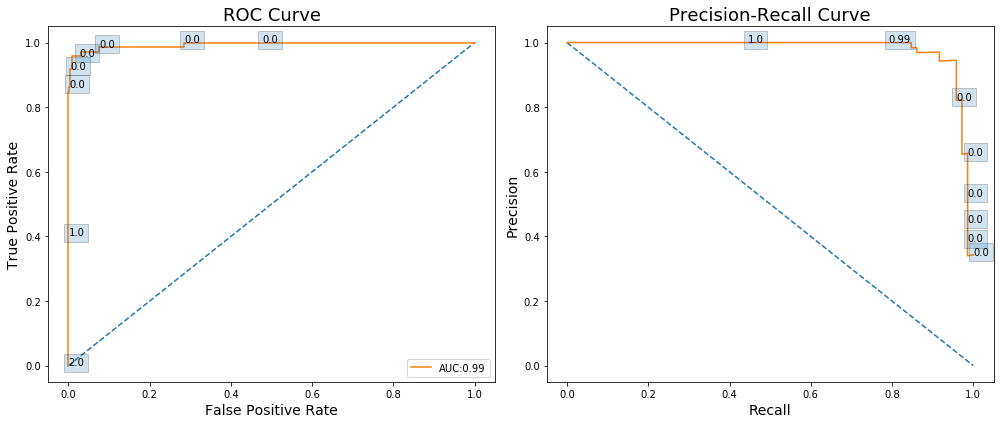

In [47]:
fig, ax = plt.subplots(1, 2,figsize=(14,6))

bern_nb_filter = spam_filter(bern_nb, X_train, X_valid, 
                             y_train, y_valid, ax,
                             TfidfVectorizer())
plt.tight_layout()

Multinomial Naive Bayes:

Confusion Matrix:
[[485   0]
 [ 19  53]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       485
           1       1.00      0.74      0.85        72

    accuracy                           0.97       557
   macro avg       0.98      0.87      0.91       557
weighted avg       0.97      0.97      0.96       557



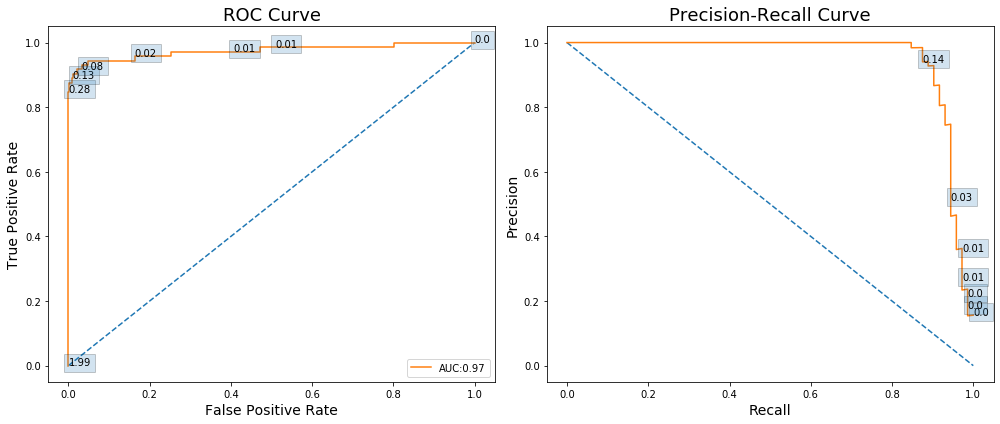

In [48]:
fig, ax = plt.subplots(1, 2,figsize=(14,6))

mult_nb_filter = spam_filter(mult_nb, X_train, X_valid, 
                             y_train, y_valid, ax,
                             TfidfVectorizer())
plt.tight_layout()

**Initial Filtering**

The most important consideration for a spam classifier is to minimize the number of false positives (we don not want legitimate messages ending up on the spam box). The models tested all have precision equal to 1 (when using a threshold of 0.5).

Next, we look at the false negatives rate (spam messages that end up on our inbox). The Random Forest and the Bernoulli Naive Bayes show the best recall score. We will keep these two models and try to improve the overall performance.  

Obs: We can change the probability threshold to improve the recall score by paying the cost of reducing the precision score.

## Improving the Best Models

### Generating New Features

First, we will try to engineer some new features that might help improving our model performance. Let's start with the count of words for each message:

In [13]:
vectorizer = CountVectorizer()
train_count = np.array(vectorizer.fit_transform(X_train).sum(axis=1))
valid_count = np.array(vectorizer.transform(X_valid).sum(axis=1))
words = vectorizer.get_feature_names()

The distribtuion of counts for spam messages is shifted to the right. On average, spam messages have more words. This could be useful for out classifier.

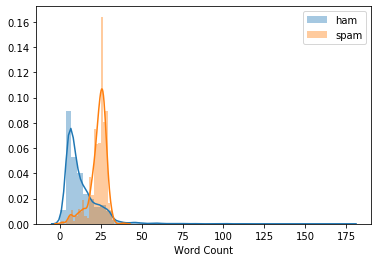

In [50]:
sns.distplot(train_count[y_train==0], label='ham');
ax = sns.distplot(train_count[y_train==1], label='spam');
ax.set_xlabel('Word Count')
plt.legend();

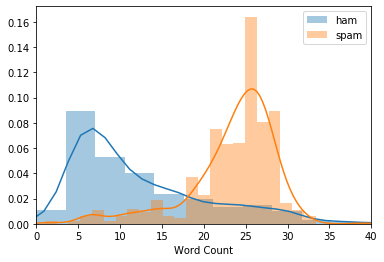

In [51]:
# zooming in
sns.distplot(train_count[y_train==0], label='ham');
ax = sns.distplot(train_count[y_train==1], label='spam');
ax.set_xlabel('Word Count')
ax.set_xlim(0, 40)
plt.legend();

Let's check if there is a similar conclusion for numbers on messages. We will get the count of numbers for every message using a simple regular expression.

In [14]:
# find numbers like '2,000', '876-234-2934', '234'
train_numbers = [re.findall(r'(?:\d+),?-?(?:\d+)-?(?:\d+)',X_train.iloc[i]) for i in range(X_train.shape[0])]
valid_numbers = [re.findall(r'(?:\d+),?-?(?:\d+)-?(?:\d+)',X_valid.iloc[i]) for i in range(X_valid.shape[0])]

In [15]:
train_numbers_count = np.array([len(numbers) for numbers in train_numbers]).reshape(-1, 1)
valid_numbers_count = np.array([len(numbers) for numbers in valid_numbers]).reshape(-1, 1)

Spam messages usually have numbers, while most ham (no-spam) messages have zero or one number only:

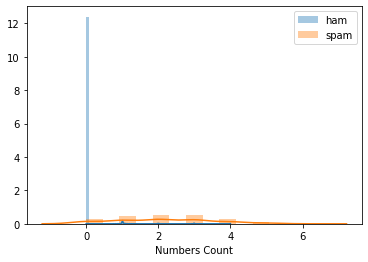

In [55]:
sns.distplot(train_numbers_count[y_train==0], label='ham');
ax = sns.distplot(train_numbers_count[y_train==1], label='spam');
ax.set_xlabel('Numbers Count')
plt.legend();

Finally, let's see if the number of punctuation markers makes a difference:

In [16]:
def get_punctuation(text):
    return sum([1 for character in text if character in string.punctuation])

In [17]:
train_punctuation_count = np.array([get_punctuation(text) for text in X_train]).reshape(-1, 1)
valid_punctuation_count = np.array([get_punctuation(text) for text in X_valid]).reshape(-1, 1)

The difference seems to be less pronounced for this one:

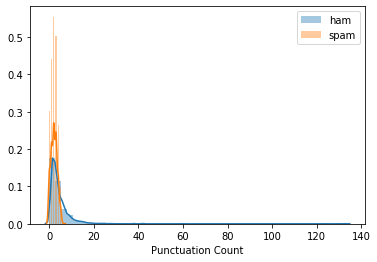

In [58]:
sns.distplot(train_punctuation_count[y_train==0], label='ham');
ax = sns.distplot(train_numbers_count[y_train==1], label='spam');
ax.set_xlabel('Punctuation Count')
plt.legend();

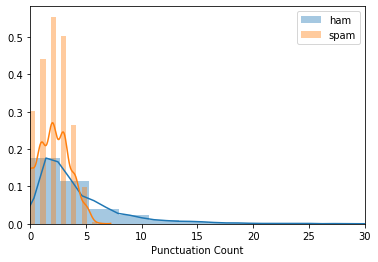

In [59]:
# zoom
sns.distplot(train_punctuation_count[y_train==0], label='ham');
ax = sns.distplot(train_numbers_count[y_train==1], label='spam');
ax.set_xlabel('Punctuation Count')
ax.set_xlim(0, 30)
plt.legend();

### Training Models with New Features

First we have to create a matrix of features with the words representation and our new features:

In [18]:
vectorizer = TfidfVectorizer()
X_train_proc = vectorizer.fit_transform(X_train)
X_valid_proc = vectorizer.transform(X_valid)

Adding features to the sparse matrices:

In [19]:
import scipy.sparse

In [20]:
import scipy.sparse
X_train_final = scipy.sparse.hstack([X_train_proc,
                                     train_count,
                                     train_numbers_count,
                                     train_punctuation_count]).tocsr()

In [21]:
X_valid_final = scipy.sparse.hstack([X_valid_proc,
                                     valid_count,
                                     valid_numbers_count,
                                     valid_punctuation_count]).tocsr()

By using the new features, we are able to increase the validation set recall from 0.82 to 0.89.

Confusion Matrix:
[[485   0]
 [  8  64]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       485
           1       1.00      0.89      0.94        72

    accuracy                           0.99       557
   macro avg       0.99      0.94      0.97       557
weighted avg       0.99      0.99      0.99       557



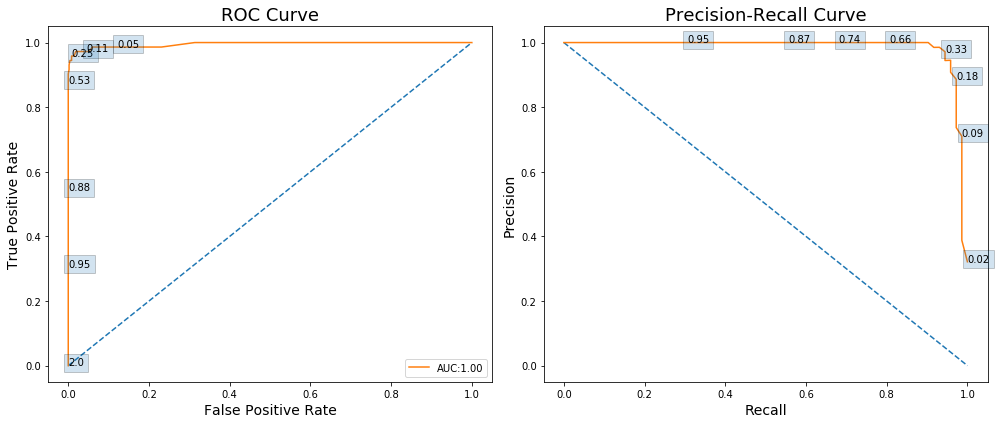

In [22]:
fig, ax = plt.subplots(1, 2,figsize=(14,6))

rnd_for_filter = spam_filter(rnd_for, X_train_final, X_valid_final, 
                             y_train, y_valid, ax)
plt.tight_layout()

Let's check if the added features are important:

In [23]:
columns = words
columns.extend(['word_count', 'number_count', 'punctuation_count'])

In [24]:
table = pd.DataFrame(dict(columns=columns, importance=rnd_for_filter['model'].feature_importances_)).reset_index(drop=True)

We can see that the count of numbers is by far the most important feature on our model, followed by the count of words. After those, some individual words are important: mobile, call, txt, www, free, etc.

In [25]:
table.sort_values(by='importance', ascending=False).head(10)

,columns,importance
7703,number_count,0.187022
7702,word_count,0.025657
4516,mobile,0.020254
1607,call,0.019350
7049,txt,0.017862
7597,www,0.015988
2959,free,0.014001
1817,claim,0.012884
7075,uk,0.011896
6461,stop,0.011840


### Undersampling

Getting spam and ham row indexes:

In [26]:
spam_rows = y_train.reset_index(drop=True)[y_train.reset_index(drop=True) == 1].index.values
ham_rows = y_train.reset_index(drop=True)[y_train.reset_index(drop=True) == 0].index.values

We now undersample the ham_row, so that both classes are balanced, and create a vector with all indexes.

In [27]:
np.random.seed(42)
train_rows = np.append(spam_rows, np.random.choice(ham_rows, len(spam_rows)))

Great, our model performance improves a little more:

Confusion Matrix:
[[485   0]
 [  6  66]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       485
           1       1.00      0.92      0.96        72

    accuracy                           0.99       557
   macro avg       0.99      0.96      0.98       557
weighted avg       0.99      0.99      0.99       557



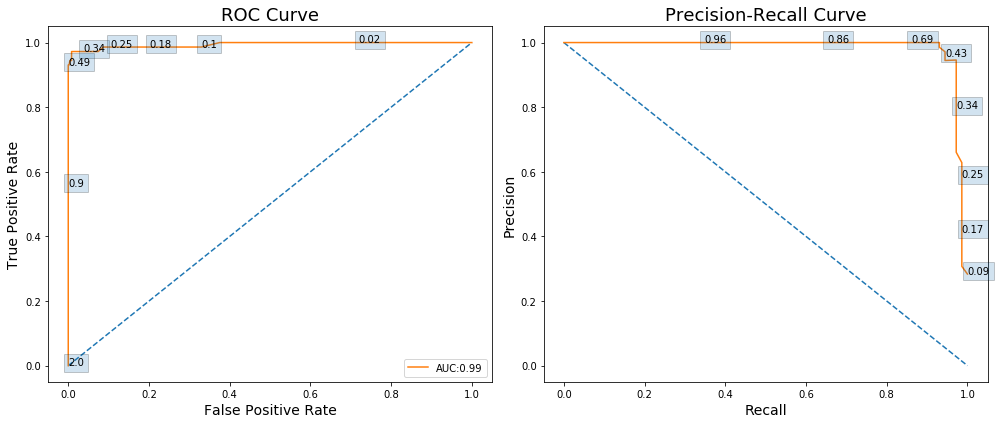

In [28]:
fig, ax = plt.subplots(1, 2,figsize=(14,6))

rnd_for_filter = spam_filter(rnd_for, X_train_final[train_rows, :], 
                             X_valid_final, 
                             y_train.iloc[train_rows], y_valid, ax)
plt.tight_layout()

### GridSearchCV

Cross Validation and Parameter Tuning:

In [38]:
param_grid_rf = [{'n_estimators':[90, 95, 100,105,110,115],
                  'max_features':[None, 'log2', 'sqrt'],
                  'min_samples_leaf':[1,3,5,10,25]
}]

In [39]:
gs_rf_tfidf = GridSearchCV(rnd_for, param_grid_rf, 
                           scoring={'AUC':'roc_auc',
                                    'precision':'precision',
                                    'recall':'recall'},
                           cv=5, n_jobs=-1, verbose=1,
                           refit=False)

In [40]:
gs_rf_tfidf.fit(X_train_final[train_rows, :], y_train.iloc[train_rows])

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.3min finished
C:\Users\USUARIO\Anaconda3\envs\playground\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'max_

In [41]:
cv_results = pd.DataFrame(dict(AUC = gs_rf_tfidf.cv_results_['mean_test_AUC'],
                  Precision = gs_rf_tfidf.cv_results_['mean_test_precision'],
                  Recall = gs_rf_tfidf.cv_results_['mean_test_recall'],
                  Parameters = [str(parameters) for parameters in gs_rf_tfidf.cv_results_['params']]))

In [42]:
# Best Model
cv_results.sort_values(by='Recall', ascending=False).iloc[0, 3]

"{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 95}"

Confusion Matrix:
[[485   0]
 [  6  66]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       485
           1       1.00      0.92      0.96        72

    accuracy                           0.99       557
   macro avg       0.99      0.96      0.98       557
weighted avg       0.99      0.99      0.99       557



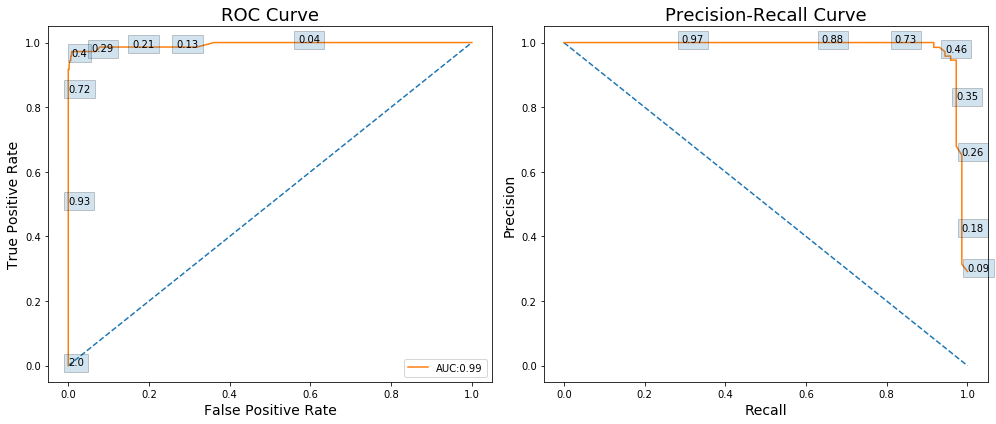

In [89]:
rnd_for = RandomForestClassifier(n_estimators=95, max_features = 'sqrt', 
                                 min_samples_leaf=1, random_state=42)

fig, ax = plt.subplots(1, 2,figsize=(14,6))

rnd_for_filter = spam_filter(rnd_for, X_train_final[train_rows, :], 
                             X_valid_final, 
                             y_train.iloc[train_rows], y_valid, ax)
plt.tight_layout()

## Pipeline for the Test Data (Summary)

Predicting spam/ham on the test set

In [78]:
# tfidf representation
X_test_proc = vectorizer.transform(X_test)
# word count
test_count = np.array(vectorizer.transform(X_test).sum(axis=1))
# numbers on test messages
test_numbers = [re.findall(r'(?:\d+),?-?(?:\d+)-?(?:\d+)',X_test.iloc[i]) for i in range(X_test.shape[0])]
test_numbers_count = np.array([len(numbers) for numbers in test_numbers]).reshape(-1, 1)
# punctuation on test messages
test_punctuation_count = np.array([get_punctuation(text) for text in X_test]).reshape(-1, 1)
# final test set
X_test_final = scipy.sparse.hstack([X_test_proc,
                                     test_count,
                                     test_numbers_count,
                                     test_punctuation_count]).tocsr()

The performance on the test set has worse precision (from 1.00 to .97) and better recall (from 0.92 to 0.95). Overall a more balanced result, as can be seen from the increase on the F1-Score from 0.92 to 0.96.

Confusion Matrix:
[[479   2]
 [  4  73]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       481
           1       0.97      0.95      0.96        77

    accuracy                           0.99       558
   macro avg       0.98      0.97      0.98       558
weighted avg       0.99      0.99      0.99       558



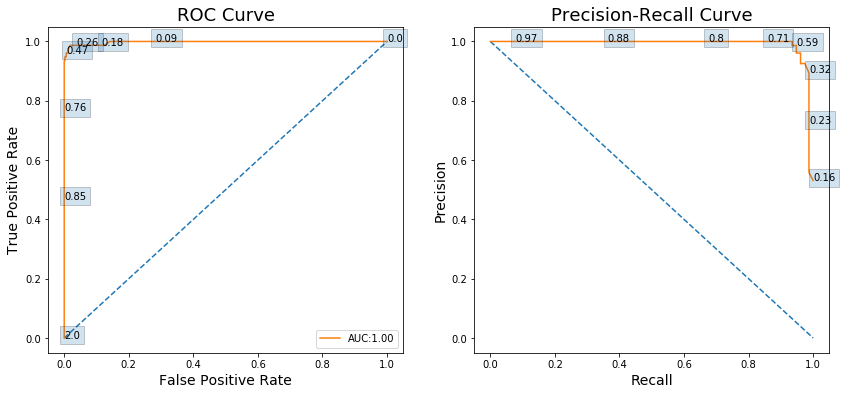

In [81]:
rnd_for = RandomForestClassifier(n_estimators=95, max_features = 'sqrt', 
                                 min_samples_leaf=1, random_state=42)

fig, ax = plt.subplots(1, 2,figsize=(14,6))

rnd_for_filter = spam_filter(rnd_for, X_train_final[train_rows, :], 
                             X_test_final, 
                             y_train.iloc[train_rows], y_test, ax)

Let's visualize the missclassified examples:

In [52]:
y_pred = rnd_for_filter['y_pred']

In [53]:
# false positives
print('\nFALSE POSITIVES:')
print(X_test[(y_test == 0) & (y_pred == 1)].iloc[0])
print(X_test[(y_test == 0) & (y_pred == 1)].iloc[1])
# false negatives
print('\nFALSE NEGATIVES:')
print(X_test[(y_test == 1) & (y_pred == 0)].iloc[0])
print(X_test[(y_test == 1) & (y_pred == 0)].iloc[1])
print(X_test[(y_test == 1) & (y_pred == 0)].iloc[2])


FALSE POSITIVES:
645
Is toshiba portege m100 gd?

FALSE NEGATIVES:
Mobile Club: Choose any of the top quality items for your mobile. 7cfca1a
Your next amazing xxx PICSFREE1 video will be sent to you enjoy! If one vid is not enough for 2day text back the keyword PICSFREE1 to get the next video.
Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES
